In [114]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F
import gin
from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
import gin
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.config.config import Config
from sparse_causal_model_learner_rl.trainable.decoder import IdentityDecoder
from keychest.keychestenv import obss_to_rgb
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/common.gin', '../keychest/config/5x5.gin'])

['common', '5x5']

In [3]:
learner = CausalModelLearnerRL(Config())
env = learner.env
h, w, c = env.engine._observation.shape

Make environment KeyChest-v0 None {}


In [4]:
def get_xy(steps=1000):
    """Get the dataset."""
    gin.bind_parameter('Config.feature_shape', None)
    gin.bind_parameter('KeyChestEnvironment.flatten_observation', True)
    gin.bind_parameter('Config.env_steps', steps)
    gin.bind_parameter('Config.decoder', None)
    gin.bind_parameter('Config.model', None)
    gin.bind_parameter('Config.reconstructor', None)
    gin.bind_parameter('Config.value_predictor', None)
    learner = CausalModelLearnerRL(Config())
    learner.collect_steps(do_tqdm=True)
    obs_x = learner._context.get('obs_x').cpu().numpy()
    obs_y = learner._context.get('obs_y').cpu().numpy()
    act_x = learner._context.get('action_x').cpu().numpy()

    X = np.concatenate((obs_x, act_x), axis=1)
    y = obs_y
    return X, y

In [95]:
X, _ = get_xy(100)
X = X[:, :-4]
X = X.reshape((-1, h, w, c))
X_rgb = obss_to_rgb(X, env.engine)

Make environment KeyChest-v0 None {}



3.0


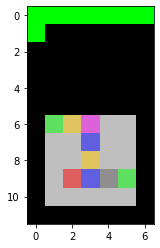

In [96]:
plt.imshow(X_rgb[0])

In [97]:
def dict_to_arr(d):
    """Dictionary to a list with keys sorted."""
    return np.array([d[k] for k in sorted(d.keys())], dtype=np.float32)

In [202]:
def arr_to_dict(arr, keys):
    """Array back to dictionary."""
    assert len(arr) == len(keys)
    return {x: y for x, y in zip(sorted(keys), arr)}

In [98]:
def obs_features_handcoded(obs, env):
    """Get features for an observation."""
    engine = env.engine
    
    def get_map(key):
        idx = engine.OBJECTS.index(key)
        return obs[:, :, idx]
    
    result = {}
    result['health'] = np.sum(get_map('health'))
    result['keys'] = np.sum(get_map('keys_collected'))
    lamp_on = np.sum(get_map('lamp_on'))
    lamp_off = np.sum(get_map('lamp_off'))
    result['lamp_status'] = 1 if lamp_on else (0 if lamp_off else -1)
    
    n_keys = gin.query_parameter('KeyChestEnvironmentRandom.n_keys')
    n_chests = gin.query_parameter('KeyChestEnvironmentRandom.n_chests')
    n_food = gin.query_parameter('KeyChestEnvironmentRandom.n_food')
    
    objects_to_out = ['key', 'chest', 'food', 'button', 'player', 'lamp_on', 'lamp_off']
    objects_cnt = {'key': n_keys, 'chest': n_chests, 'food': n_food}
    
    def register(key, x, y, idx=None):
        if x is None:
            x = -1
        if y is None:
            y = -1
        name_prefix = key + "_"
        if idx is not None:
            name_prefix = "%s%02d_" % (name_prefix, idx)
        
        result[name_prefix + "x"] = x
        result[name_prefix + "y"] = y
    
    def arr_get_val(arr, idx):
        if idx < len(arr):
            x, y = arr[idx]
        else:
            x, y = -1, -1
        return x, y
    
    for key in objects_to_out:
        m = get_map(key)
        where = sorted(list(zip(*np.where(m))))
#         print(key, where)
        assert len(where) <= 1 or key in objects_cnt
        
        if key in objects_cnt:
            for i in range(objects_cnt[key]):
                x, y = arr_get_val(where, i)
                register(key, x, y, i)
        else:
            x, y = arr_get_val(where, 0)
            register(key, x, y, None)
    
    return result

In [115]:
Fdict = [obs_features_handcoded(x, env) for x in X]
F = np.array([dict_to_arr(f) for f in Fdict])

In [186]:
Fkeys = Fdict[0].keys()

In [100]:
f = obs_features_handcoded(X[0], env)

In [101]:
dict_to_arr(f)

array([ 6.,  3.,  6.,  2.,  8.,  3.,  6.,  1.,  9.,  5.,  8.,  7.,  3.,
        9.,  3.,  0.,  9.,  4., -1., -1.,  0.,  9.,  2.], dtype=float32)

In [102]:
X_rgb[0].shape

(12, 7, 3)

In [103]:
F.shape

(112, 23)

{'health': 6.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 6, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 5, 'chest_01_x': 8, 'chest_01_y': 4, 'food_00_x': 7, 'food_00_y': 1, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 9, 'button_y': 1, 'player_x': 10, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 4}


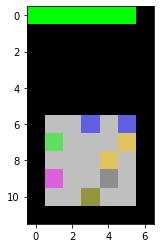

{'health': 7.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 8, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': 9, 'food_00_y': 4, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 3, 'player_x': 9, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


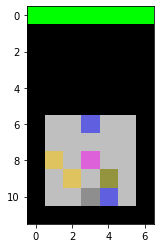

{'health': 2.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 8, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': -1, 'food_00_y': -1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 3, 'player_x': 7, 'player_y': 2, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


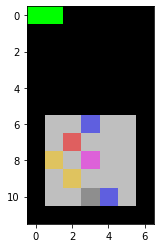

{'health': 14.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 8, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': -1, 'food_00_y': -1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 3, 'player_x': 9, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


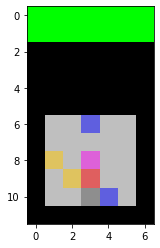

{'health': 4.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 4, 'key_01_x': 9, 'key_01_y': 4, 'chest_00_x': 7, 'chest_00_y': 1, 'chest_01_x': 8, 'chest_01_y': 5, 'food_00_x': 8, 'food_00_y': 3, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 7, 'button_y': 2, 'player_x': 9, 'player_y': 5, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 1}


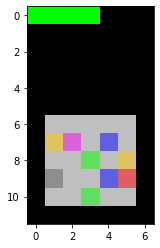

{'health': 7.0, 'keys': 1.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 3, 'key_01_x': -1, 'key_01_y': -1, 'chest_00_x': 6, 'chest_00_y': 2, 'chest_01_x': 8, 'chest_01_y': 3, 'food_00_x': 6, 'food_00_y': 1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 6, 'button_y': 3, 'player_x': 9, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 4}


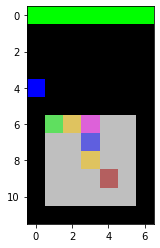

{'health': 6.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 8, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': -1, 'food_00_y': -1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 3, 'player_x': 7, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


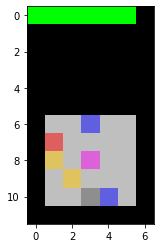

{'health': 7.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 8, 'chest_00_y': 1, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': -1, 'food_00_y': -1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 3, 'player_x': 7, 'player_y': 2, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 3}


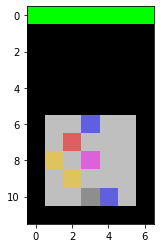

{'health': 1.0, 'keys': 1.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 4, 'key_01_x': -1, 'key_01_y': -1, 'chest_00_x': 7, 'chest_00_y': 1, 'chest_01_x': 8, 'chest_01_y': 5, 'food_00_x': 8, 'food_00_y': 3, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 7, 'button_y': 2, 'player_x': 9, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 1}


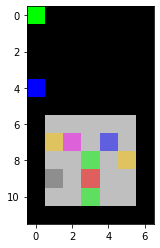

{'health': 12.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 3, 'key_01_x': 6, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 5, 'chest_01_x': 8, 'chest_01_y': 4, 'food_00_x': 7, 'food_00_y': 1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 9, 'button_y': 1, 'player_x': 10, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 4}


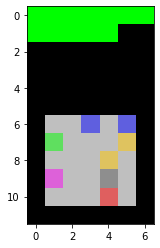

In [104]:
for i in range(10):
    idx = np.random.choice(len(X))
#     idx = i
    print(Fdict[idx])
    plt.imshow(X_rgb[idx])
    plt.show()

# Embedder model

In [157]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(h * w * c, )),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(F.shape[1], activation=None)
])

In [158]:
model.compile(tf.optimizers.Adam(lr=1e-4), 'mse', metrics=['mae'])

In [168]:
import sklearn

In [174]:
Xn_scaler = sklearn.preprocessing.StandardScaler()
Fn_scaler = sklearn.preprocessing.StandardScaler()

In [175]:
Xn = Xn_scaler.fit_transform(X.reshape(X.shape[0], -1))
Fn = Fn_scaler.fit_transform(F)

In [176]:
history = model.fit(Xn, Fn, epochs=50000, validation_split=0.1, batch_size=512, verbose=0)#, callbacks=[TQDMNotebookCallback(leave_inner=False)])

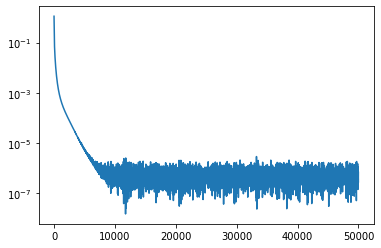

In [177]:
plt.plot(history.history['loss'])
plt.yscale('log')

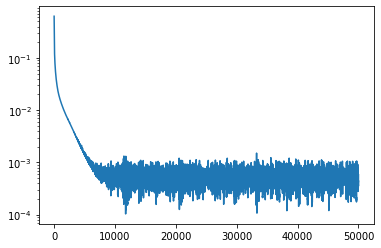

In [178]:
plt.plot(history.history['mae'])
plt.yscale('log')

In [179]:
np.std(F, axis=0)

array([1.0594571 , 0.8206519 , 0.8806297 , 1.5859714 , 0.9583142 ,
       1.3720978 , 2.964017  , 1.6557866 , 4.878883  , 2.4294739 ,
       3.3204684 , 0.94220704, 0.98958194, 4.1443944 , 2.0852184 ,
       0.39031237, 2.4419277 , 1.4690695 , 2.275367  , 0.90068007,
       0.22517003, 1.1940271 , 1.1724683 ], dtype=float32)

In [180]:
np.mean(F, axis=0)

array([ 7.857143  ,  2.4285715 ,  7.285714  ,  2.642857  ,  8.285714  ,
        3.2142856 ,  6.232143  ,  2.1875    ,  3.6339285 ,  1.1875    ,
        6.214286  ,  6.571429  ,  3.0535715 ,  7.142857  ,  2.8660715 ,
        0.1875    ,  8.464286  ,  2.357143  , -0.4642857 , -0.78571427,
        0.05357143,  8.446428  ,  2.767857  ], dtype=float32)

In [181]:
model

In [182]:
model.evaluate(Xn, Fn)

[0.005230538800739331, 0.017428977]

In [183]:
assert len(X_rgb) == len(Xn)

,pred,true,error
button_x,8.000434,8.0,0.000434
button_y,1.999969,2.0,0.000031
chest_00_x,9.000382,9.0,0.000382
chest_00_y,2.000165,2.0,0.000165
chest_01_x,9.998533,10.0,0.001467
chest_01_y,2.000516,2.0,0.000516
food_00_x,8.006310,8.0,0.006310
food_00_y,3.999834,4.0,0.000166
food_01_x,9.999562,10.0,0.000438
food_01_y,3.999169,4.0,0.000831


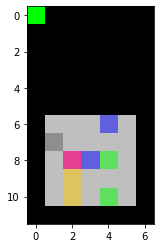

In [218]:
idx = np.random.choice(len(Xn))
img = X_rgb[idx]
Xn_idx = Xn[idx:idx+1]
f_pred = model.predict(Xn_idx)[0]
f_pred_scaled = f_pred * (Fn_scaler.var_ ** 0.5) + Fn_scaler.mean_
f_pred_dct = arr_to_dict(f_pred_scaled, Fkeys)
f_true_dct = Fdict[idx]

# print(f_pred_dct, f_true_dct)
plt.imshow(img)
df = pd.DataFrame({'pred': f_pred_dct, 'true': f_true_dct})
df['error'] = np.abs(df.pred - df.true)
df

# Generator model

In [319]:
generator = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(F.shape[1], )),
    tf.keras.layers.Dense(2048, activation='sigmoid'),
    tf.keras.layers.Dense(2048, activation='sigmoid'),
    tf.keras.layers.Dense((h * w * c), activation=None),
#     tf.keras.layers.Reshape((h, w, c))
])

In [320]:
generator.compile(tf.optimizers.Adam(lr=1e-4), 'mse', metrics=['mae'])

In [ ]:
history = generator.fit(Fn, Xn, epochs=50000, validation_split=0.1, batch_size=512, verbose=0)#, callbacks=[TQDMNotebookCallback(leave_inner=False)])

In [ ]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [ ]:
plt.plot(history.history['mae'])
plt.yscale('log')

In [ ]:
generator.evaluate(Fn, Xn)

In [ ]:
idx = np.random.choice(len(Xn))


img_true = X_rgb[idx]
Fn_idx = Fn[idx:idx+1]
img_pred_flat = generator.predict(Fn_idx)
img_pred_flat_rescaled = (img_pred_flat * (Xn_scaler.var_ ** 0.5) + Xn_scaler.mean_)
img_pred = img_pred_flat_rescaled.reshape((1, h, w, c))
img_pred_rgb = obss_to_rgb(img_pred, env.engine)[0]
Fdict_idx = Fdict[idx]

print(idx, Fdict_idx)

img_pred_rgb[img_pred_rgb > 1] = 1
img_pred_rgb[img_pred_rgb < 0] = 0

plt.subplot(1, 3, 1)
plt.title('pred')
plt.imshow(img_pred_rgb)
plt.subplot(1, 3, 2)
plt.title('true')
plt.imshow(img_true)
plt.subplot(1, 3, 3)
plt.title('err')
plt.imshow(np.abs(img_pred_rgb - img_true))
plt.show()

In [ ]:
plt.imshow(X_rgb[idx])